<a href="https://colab.research.google.com/github/polevev/kaggle/blob/main/%D0%A0%D0%BE%D0%B6%D0%B4%D0%B0%D0%B5%D0%BC%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import pandas as pd

df = pd.read_csv('/content/rf_birthrate_dataset_full.csv')
df.sample(5)

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Браки,Разводы,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств
196,2012,Волгоградская область,1.72,80585,73.7,159386,29.3,10.0,83.5,15.4,11728,46765,28.9,16.1,0.34
1217,2023,Красноярский край,1.37,26448,51.8,42231,27.4,6.2,61.4,8.1,13104,45769,31.5,40.0,0.36
974,2020,Республика Татарстан,1.38,92870,90.7,475554,31.2,6.8,66.0,12.3,9756,34627,27.9,37.4,0.75
1120,2022,Карелия,1.66,74297,81.3,621889,37.7,6.9,99.9,14.6,39831,25945,27.6,30.3,0.88
743,2018,Вологодская область,1.69,117606,82.8,756843,25.6,6.9,75.9,10.6,36248,27456,22.5,29.7,0.34


In [144]:
df.describe()

,Год,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Браки,Разводы,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств
count,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000
mean,2016.500000,1.601813,73942.543956,73.126060,413755.927786,32.334380,6.985950,72.716562,11.967268,48386.098116,26156.496075,26.850157,28.001256,0.516256
std,4.032712,0.283485,31850.951629,13.396015,226527.631373,5.501254,2.911898,15.947922,2.323419,26454.990085,14347.613228,3.399961,8.095370,0.213797
min,2010.000000,1.100000,18030.000000,50.000000,5454.000000,23.000000,2.000000,45.000000,8.000000,3007.000000,1031.000000,21.000000,14.000000,0.150000
25%,2013.000000,1.360000,46569.500000,62.100000,220142.750000,27.500000,4.600000,58.800000,9.900000,25844.500000,13329.750000,23.900000,20.900000,0.330000
50%,2016.500000,1.605000,74865.500000,73.200000,406470.000000,32.200000,7.000000,72.800000,12.000000,48860.500000,26920.500000,26.700000,28.200000,0.520000
75%,2020.000000,1.840000,100874.500000,84.400000,613270.250000,37.000000,9.500000,86.600000,14.000000,71463.750000,38614.500000,29.700000,35.000000,0.700000
max,2023.000000,2.100000,129939.000000,95.900000,799186.000000,42.000000,12.000000,100.000000,16.000000,94968.000000,49973.000000,33.000000,42.000000,0.900000


In [145]:
from sklearn.preprocessing import LabelEncoder

scaler = LabelEncoder()

df['Регион'] = scaler.fit_transform(df['Регион'])
df['Год'] = scaler.fit_transform(df['Год'])

In [146]:
df

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Браки,Разводы,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств
0,0,36,1.69,65408,85.2,764881,23.6,4.8,78.5,14.9,57016,47501,30.4,38.1,0.67
1,0,67,1.13,87693,77.8,87881,41.8,8.5,70.3,8.6,14201,43197,31.4,25.7,0.66
2,0,37,1.27,51566,89.0,669774,28.9,4.4,98.9,8.2,93589,49305,25.3,15.2,0.57
3,0,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,5322,36630,25.0,25.2,0.62
4,0,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,32765,2228,24.0,16.4,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,13,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,77448,45559,29.8,32.3,0.65
1270,13,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,79485,44067,27.7,15.0,0.62
1271,13,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,78992,3434,32.0,40.1,0.25
1272,13,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,59483,44638,25.6,41.7,0.25


In [6]:
df_1 = pd.DataFrame(df[df['Регион']==88],columns=df.columns)

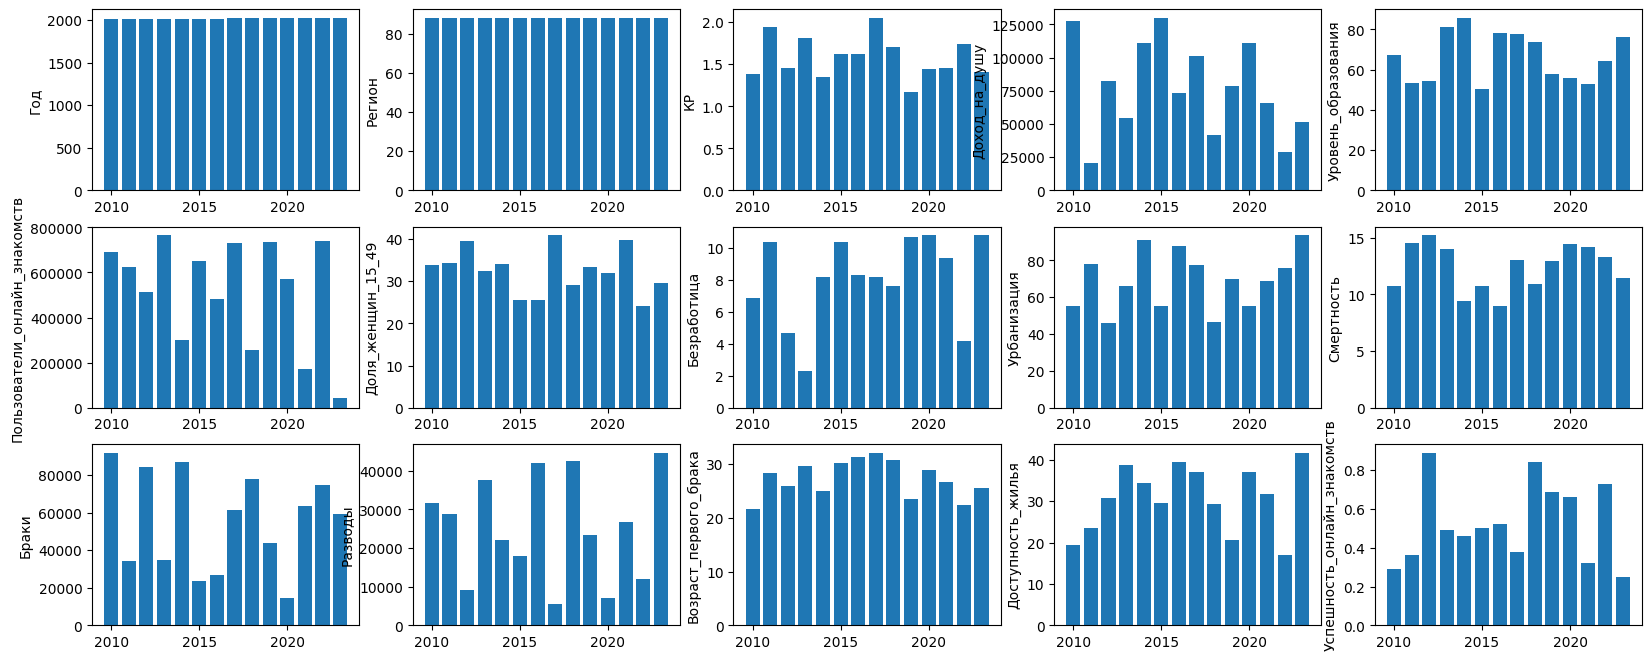

In [7]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(3, 5)
fig.set_size_inches(20, 8)
i = 0
j = 0
for column in df.columns:
  axes[i,j].bar(df_1['Год'], df_1[column])
  axes[i,j].set_ylabel(column)
  j+=1
  if j%5==0:
    i+=1
    j=0
plt.show()

In [147]:
df['Браки/разводы'] = df['Браки']/df['Разводы']

In [148]:
df.drop(columns=['Браки','Разводы'], inplace=True)

In [149]:
df

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств,Браки/разводы
0,0,36,1.69,65408,85.2,764881,23.6,4.8,78.5,14.9,30.4,38.1,0.67,1.200312
1,0,67,1.13,87693,77.8,87881,41.8,8.5,70.3,8.6,31.4,25.7,0.66,0.328750
2,0,37,1.27,51566,89.0,669774,28.9,4.4,98.9,8.2,25.3,15.2,0.57,1.898164
3,0,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,25.0,25.2,0.62,0.145291
4,0,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,24.0,16.4,0.26,14.706014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,13,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,29.8,32.3,0.65,1.699950
1270,13,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,27.7,15.0,0.62,1.803731
1271,13,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,32.0,40.1,0.25,23.002912
1272,13,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,25.6,41.7,0.25,1.332564


In [150]:
df = df.sort_values('Год').dropna()
df['lag_1'] = df['Успешность_онлайн_знакомств'].shift(1)
df = df.dropna()

In [151]:
df

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств,Браки/разводы,lag_1
1,0,67,1.13,87693,77.8,87881,41.8,8.5,70.3,8.6,31.4,25.7,0.66,0.328750,0.67
2,0,37,1.27,51566,89.0,669774,28.9,4.4,98.9,8.2,25.3,15.2,0.57,1.898164,0.66
3,0,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,25.0,25.2,0.62,0.145291,0.57
4,0,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,24.0,16.4,0.26,14.706014,0.62
5,0,50,1.66,53402,93.7,265419,36.6,2.3,84.9,12.8,27.7,15.7,0.21,0.619972,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,13,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,29.8,32.3,0.65,1.699950,0.39
1270,13,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,27.7,15.0,0.62,1.803731,0.65
1271,13,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,32.0,40.1,0.25,23.002912,0.62
1272,13,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,25.6,41.7,0.25,1.332564,0.25


In [152]:
df['rolling_mean'] = df['Успешность_онлайн_знакомств'].rolling(window=3).mean()
df['year_sin'] = np.sin(2 * np.pi * df['Год'] / 10)

In [153]:
df

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств,Браки/разводы,lag_1,rolling_mean,year_sin
1,0,67,1.13,87693,77.8,87881,41.8,8.5,70.3,8.6,31.4,25.7,0.66,0.328750,0.67,NaN,0.000000
2,0,37,1.27,51566,89.0,669774,28.9,4.4,98.9,8.2,25.3,15.2,0.57,1.898164,0.66,NaN,0.000000
3,0,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,25.0,25.2,0.62,0.145291,0.57,0.616667,0.000000
4,0,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,24.0,16.4,0.26,14.706014,0.62,0.483333,0.000000
5,0,50,1.66,53402,93.7,265419,36.6,2.3,84.9,12.8,27.7,15.7,0.21,0.619972,0.26,0.363333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,13,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,29.8,32.3,0.65,1.699950,0.39,0.420000,0.951057
1270,13,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,27.7,15.0,0.62,1.803731,0.65,0.553333,0.951057
1271,13,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,32.0,40.1,0.25,23.002912,0.62,0.506667,0.951057
1272,13,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,25.6,41.7,0.25,1.332564,0.25,0.373333,0.951057


In [154]:
df = df.dropna()

<Axes: >

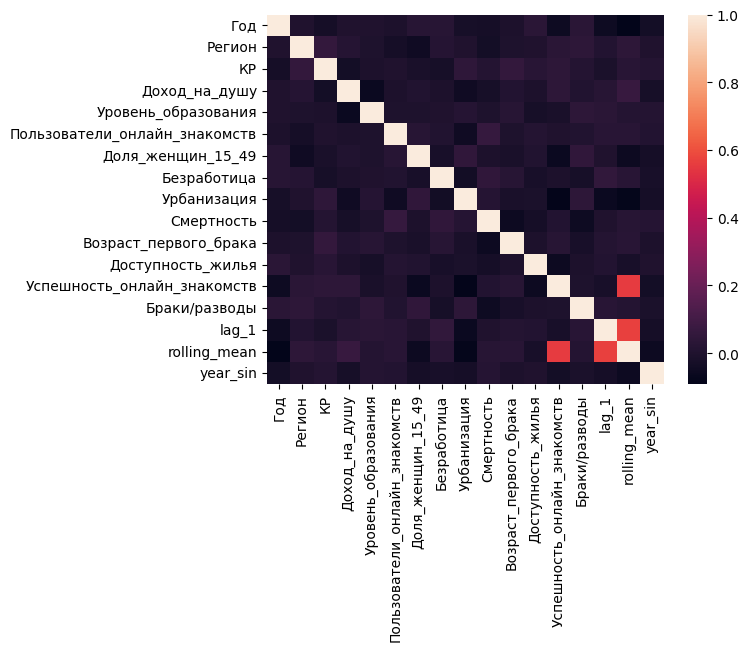

In [155]:
import seaborn as sns
sns.heatmap(df.corr(numeric_only=True))

In [156]:
df_origin = df.copy()

In [159]:
from sklearn.preprocessing import StandardScaler

Scaler =  StandardScaler()

df_origin['lag_1'] = Scaler.fit_transform(df_origin[['lag_1']])

In [160]:
df_origin = pd.DataFrame(df_origin, columns = df.columns)

In [161]:
df_origin

,Год,Регион,КР,Доход_на_душу,Уровень_образования,Пользователи_онлайн_знакомств,Доля_женщин_15_49,Безработица,Урбанизация,Смертность,Возраст_первого_брака,Доступность_жилья,Успешность_онлайн_знакомств,Браки/разводы,lag_1,rolling_mean,year_sin
3,0,31,1.84,34946,68.5,695238,30.8,8.9,85.6,10.6,25.0,25.2,0.62,0.145291,0.252576,0.616667,0.000000
4,0,71,1.66,110735,78.5,489504,26.8,12.0,74.4,8.6,24.0,16.4,0.26,14.706014,0.486354,0.483333,0.000000
5,0,50,1.66,53402,93.7,265419,36.6,2.3,84.9,12.8,27.7,15.7,0.21,0.619972,-1.196849,0.363333,0.000000
6,0,51,1.49,112532,78.0,55499,36.7,11.3,99.5,12.9,22.0,35.8,0.37,3.986549,-1.430627,0.280000,0.000000
55,0,52,1.79,111078,52.2,474401,41.4,2.4,57.7,11.8,32.3,24.3,0.74,1.432452,-0.682537,0.440000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,13,85,1.62,125469,50.5,295880,37.9,6.0,60.1,8.0,29.8,32.3,0.65,1.699950,-0.589025,0.420000,0.951057
1270,13,86,1.28,107594,55.0,124096,36.6,10.9,70.2,11.9,27.7,15.0,0.62,1.803731,0.626621,0.553333,0.951057
1271,13,87,1.86,116447,68.8,782396,34.6,11.6,88.0,10.3,32.0,40.1,0.25,23.002912,0.486354,0.506667,0.951057
1272,13,88,1.41,51393,76.0,44252,29.6,10.8,93.6,11.4,25.6,41.7,0.25,1.332564,-1.243604,0.373333,0.951057


In [168]:
X = df.drop(columns=['Успешность_онлайн_знакомств'])
y = df['Успешность_онлайн_знакомств']

In [186]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2,stratify=y, random_state=42)

In [171]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'KNeighbors': KNeighborsRegressor(),
    'xgb': xgb.XGBRegressor(random_state=42)
}

In [187]:
from sklearn.model_selection import cross_validate, TimeSeriesSplit
import numpy as np

results = {}
for name, model in models.items():
    # Используем TimeSeriesSplit и правильные ключи метрик
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=tscv,
        scoring=['neg_mean_squared_error', 'r2']
    )
    results[name] = {
        'MSE': -np.mean(scores['test_neg_mean_squared_error']),
        'R²': np.mean(scores['test_r2'])
    }

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,MSE,R²
DecisionTree,0.054407,-0.176093
RandomForest,0.030030,0.350888
LinearRegression,0.025736,0.443594
SVR,0.047729,-0.026392
KNeighbors,0.054731,-0.176553
xgb,0.034507,0.251599


In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Определяем модель
rf_model = RandomForestRegressor(random_state=42)

# Определяем параметры для поиска
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Количество деревьев
    'max_depth': [10, 20, 30],  # Максимальная глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество сэмплов для разбиения узла
    'min_samples_leaf': [2, 4, 6],  # Минимальное количество сэмплов в листе
    'max_features': ['auto', 'sqrt', 'log2'],  # Количество признаков для поиска лучшего разбиения
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=True)

# Обучение на данных
grid_search.fit(X_train, y_train)

# Вывод лучших параметров
print("Best parameters found: ", grid_search.best_params_)

# Оценка модели с лучшими гиперпараметрами
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print(f"Best score (MSE): {best_score:.4f}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py"

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best score (MSE): -0.0286


In [188]:
scoring = ['neg_mean_squared_error', 'r2']
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_validate(best_model, X_train, y_train, cv=tscv, scoring=scoring)
scores

{'fit_time': array([0.39433146, 0.49886751, 0.66025424, 0.8836112 , 1.31012487]),
 'score_time': array([0.0302217 , 0.0259335 , 0.0283308 , 0.0508275 , 0.05174947]),
 'test_neg_mean_squared_error': array([-0.03401224, -0.03438266, -0.02388867, -0.03366928, -0.03420413]),
 'test_r2': array([0.31330275, 0.1875443 , 0.37729914, 0.31046678, 0.36206944])}

In [189]:
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [177]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [190]:
print(f'MAE:{mean_absolute_error(y_test, y_pred)}')
print(f'MSE:{mean_squared_error(y_test, y_pred)}')
print(f'R^2:{r2_score(y_test, y_pred)}')

MAE:0.07433178584451132
MSE:0.009354179389681052
R^2:0.7924414516804974


In [182]:
import torch

In [183]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(num_classes, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32,1)
        )


    def forward(self, x):
      return (self.fc(x))

In [191]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

In [192]:
train_loader = torch.utils.data.DataLoader(list(zip(X_train_tensor, y_train_tensor)), batch_size=64, shuffle=True)

In [193]:
X_train.shape

(1016, 16)

In [194]:
model = Net(num_classes=16)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [195]:
import matplotlib.pyplot as plt

In [196]:
import tqdm
from tqdm.auto import tqdm

def train_stochastic(model, loader, criterion, optimizer, num_epoch):
    # цикл по количеству эпох обучения
    total_epoch_loss = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []

        # цикл по батчам даталоадера
        for X_batch, y_batch in loader:
            # Вычислим предсказания нашей модели
            y_batch = y_batch.unsqueeze(1)
            y_pred = model(X_batch)

            # Посчитаем значение функции потерь  на полученном предсказании
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            # Выполним подсчёт новых градиентов
            loss.backward()
            # Выполним шаг градиентного спуска
            optimizer.step()
            # Обнулим сохраненные у оптимизатора значения градиентов
            # перед следующим шагом обучения
            optimizer.zero_grad()

        print(f"{t} epoch: curr_loss = {np.mean(epoch_loss)}")
        total_epoch_loss.append(epoch_loss)

    plt.figure(figsize=(10,8))
    plt.plot(range(1, num_epoch+1), total_epoch_loss, 'b-', linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.show()

    return model

  0%|          | 0/500 [00:00<?, ?it/s]

0 epoch: curr_loss = 0.3789119981229305
1 epoch: curr_loss = 0.32880844362080097
2 epoch: curr_loss = 0.29193547181785107
3 epoch: curr_loss = 0.27447155956178904
4 epoch: curr_loss = 0.27260263729840517
5 epoch: curr_loss = 0.2559502264484763
6 epoch: curr_loss = 0.25022540148347616
7 epoch: curr_loss = 0.23852468375116587
8 epoch: curr_loss = 0.22922128066420555
9 epoch: curr_loss = 0.21551755908876657
10 epoch: curr_loss = 0.22417219635099173
11 epoch: curr_loss = 0.21839463897049427
12 epoch: curr_loss = 0.2032234026119113
13 epoch: curr_loss = 0.20296332892030478
14 epoch: curr_loss = 0.19876962434500456
15 epoch: curr_loss = 0.19021097104996443
16 epoch: curr_loss = 0.18601969070732594
17 epoch: curr_loss = 0.18470635451376438
18 epoch: curr_loss = 0.18080349639058113
19 epoch: curr_loss = 0.17376658599823713
20 epoch: curr_loss = 0.16837398428469896
21 epoch: curr_loss = 0.16729480680078268
22 epoch: curr_loss = 0.16381986904889345
23 epoch: curr_loss = 0.15956020262092352
24 ep

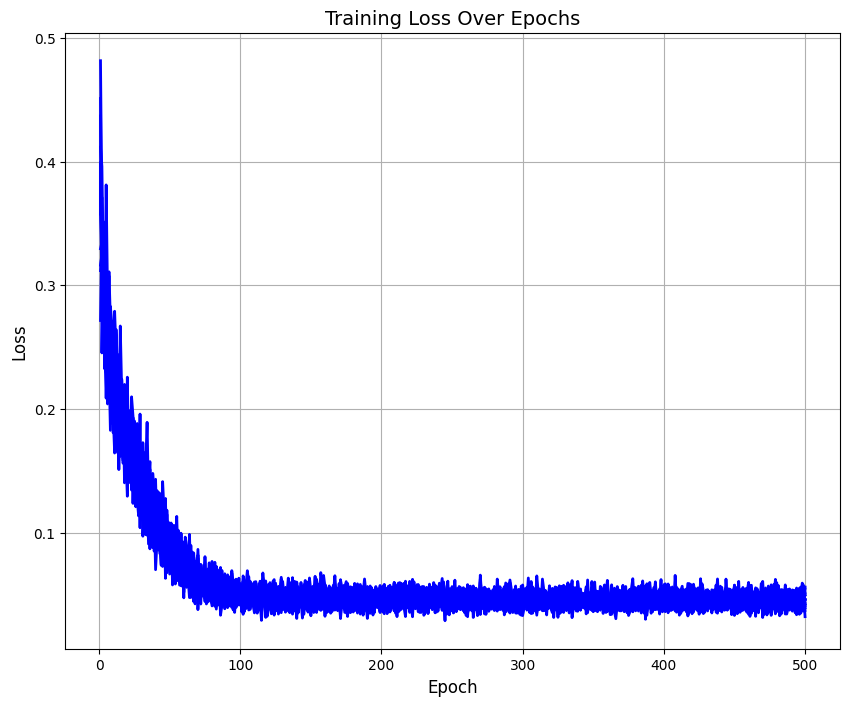

In [197]:
model = train_stochastic(model, train_loader, criterion, optimizer, 500)

In [198]:
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [199]:
with torch.no_grad():
    nn_prediction = model(torch.FloatTensor(X_test_tensor))
    nn_prediction = nn_prediction.tolist()

In [200]:
print(f'MAE:{mean_absolute_error(y_test, nn_prediction)}')
print(f'MSE:{mean_squared_error(y_test, nn_prediction)}')
print(f'R^2:{r2_score(y_test, nn_prediction)}')

MAE:0.18408571904780816
MSE:0.04600546377712298
R^2:-0.020808654458645437
